In [148]:
%matplotlib inline
# notebook stuff
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# numpy
import numpy as np
from PIL import Image

# torch stuff
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchsummary import summary
import torch.nn.functional as F

# our stuff
import importlib
import model.mdrnn  as mdrnn
MDRNN = importlib.reload(mdrnn).MDRNN

import dataset
dataset = importlib.reload(dataset)
RNNDataset = dataset.RNNDataset
MultiToTensor = dataset.MultiToTensor
from model.vaelin import VAELin
from constants import *

In [297]:
batch_size=10
sequence_length=500
hidden_space_dim=32 
action_space_dim=1
latent_space_dim=16
num_mixtures=5
rnn_type="lstm"
n_layers=1


latents = torch.randn(batch_size, sequence_length , latent_space_dim)
next_latents = torch.randn(batch_size, sequence_length , latent_space_dim)
actions = torch.randn(batch_size ,sequence_length, action_space_dim)
latents.shape, next_latents.shape, actions.shape

(torch.Size([10, 500, 16]),
 torch.Size([10, 500, 16]),
 torch.Size([10, 500, 1]))

In [298]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [299]:
vae = VAELin(z_size=16, device=device).to(device)
loaded = torch.load(VAE_PATH)
vae.load_state_dict(loaded['model_state_dict'])

dataset = RNNDataset(transform=MultiToTensor(), size=100, sample_size=sequence_length)
batch_size = 10
loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)

In [300]:

def to_latent(batch_frames, vae):
    frames = batch_frames.reshape((batch_size, sequence_length, 3, HEIGHT, WIDTH))
    latent_seq = vae(frames)[3]
    latent_seqs = latent_seq.reshape((batch_size, sequence_length, 16))
    return latent_seqs

In [301]:
model = MDRNN(batch_size, sequence_length, hidden_space_dim, action_space_dim, latent_space_dim, num_mixtures, rnn_type, n_layers).to(device)


In [302]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [303]:
epochs = 50

In [304]:
#%%
for ep in range(epochs):
    with tqdm_notebook(total=len(loader)) as bar:
        old_rnn_hidden = None
        for batch_idx, batch in enumerate(loader):
            optimizer.zero_grad()
            frame_seqs = batch['frame_seq'].to(device).float() # (BATCHSIZE, SEQ_LEN, 3, 64, 64)
            action_seqs = batch['action_seq'].to(device).float().unsqueeze(2) # (BATCHSIZE, SEQ_LEN)
            latent_seqs = to_latent(frame_seqs, vae) # (BATCHSIZE, SEQ_LEN, LATENT_SIZE)

            curr_latent = latent_seqs[:,:-1]
            curr_actions = action_seqs[:,:-1]
            next_latent = latent_seqs[:,1:]
            mus, logsigmas, logpis, rnn_out, rnn_hidden = model(curr_latent, curr_actions, old_rnn_hidden)

            loss = model.loss(next_latent, mus, logsigmas, logpis)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
            
            old_rnn_hidden = (torch.tensor(rnn_hidden[0]).detach(), torch.tensor(rnn_hidden[1]).detach())
            
            bar.update(1)
            bar.set_postfix(avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))
            
            
            


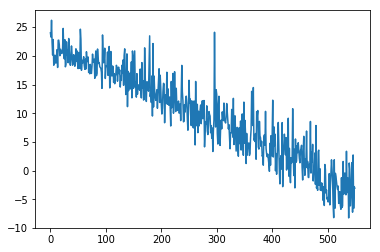

In [305]:
np_losses = np.array(losses)
plt.plot(np_losses)

In [306]:
def sample_gmm(mus, logsigmas, logpis):
    mu, logsigma, logpi = mus[0,-1], logsigmas[0,-1], logpis[0,-1]
    choice = torch.distributions.categorical.Categorical(F.softmax(logpi, dim=0)).sample()
    dist = torch.distributions.normal.Normal(mu[choice], logsigma[choice].exp())
    return dist.sample()

In [307]:
curr_latent = curr_latent[0,0].unsqueeze(0).unsqueeze(0)

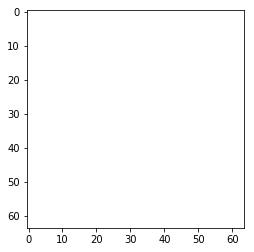

In [308]:
fig = plt.figure()
ims = []

old_rnn_hidden = None
for i in tqdm_notebook(range(1000)):
    mus, logsigmas, logpis, rnn_out, rnn_hidden = model(curr_latent, torch.randint(0,3,(1,1,1)).to(device) , old_rnn_hidden)
    old_rnn_hidden = (torch.tensor(rnn_hidden[0]).detach(), torch.tensor(rnn_hidden[1]).detach())
    next_latent = sample_gmm(mus, logsigmas, logpis)
    
    decoded = vae.decoder(next_latent).squeeze().detach().cpu().numpy().transpose((1,2,0))
    im = plt.imshow(decoded, animated=True)
    ims.append([im])
    
    curr_latent = next_latent.unsqueeze(0).unsqueeze(0)
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

In [309]:
vid = anim.to_html5_video()

In [310]:
HTML(vid)

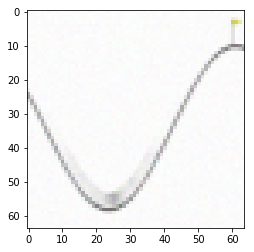

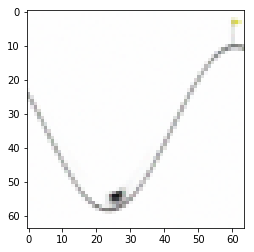

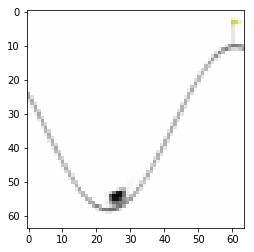

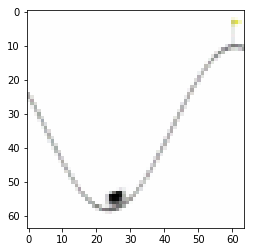

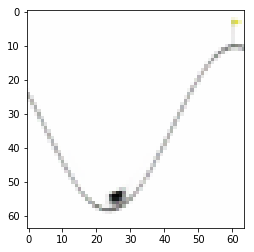

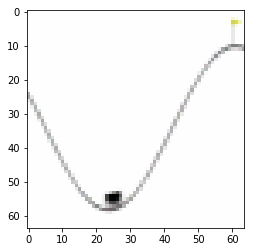

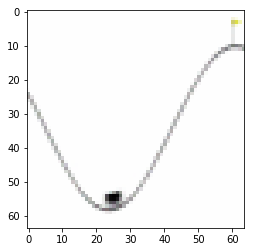

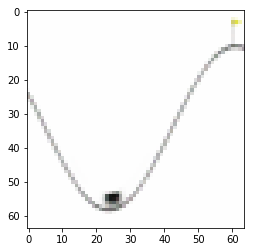

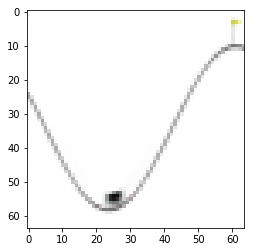

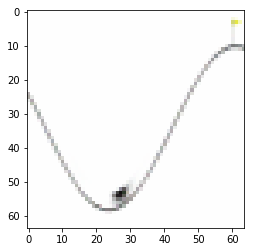

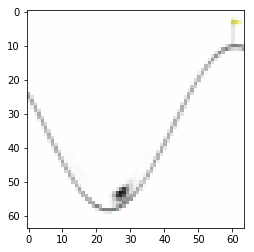

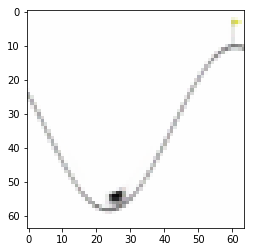

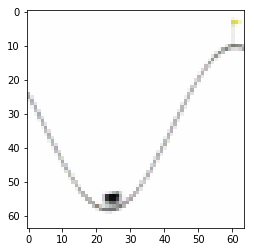

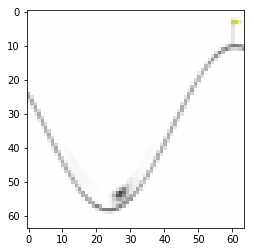

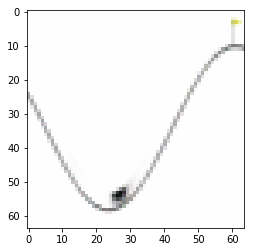

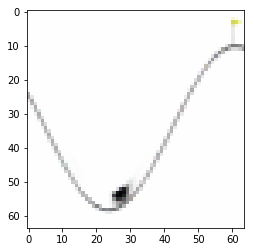

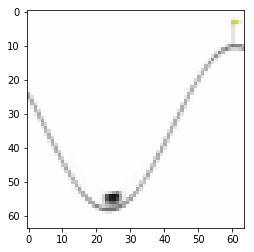

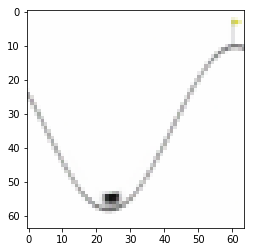

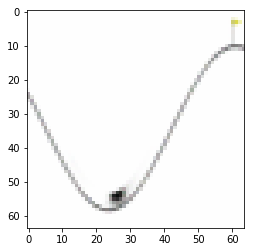

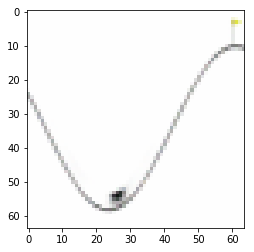

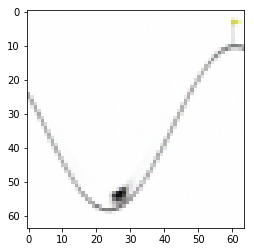

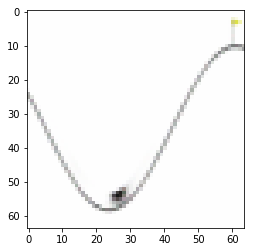

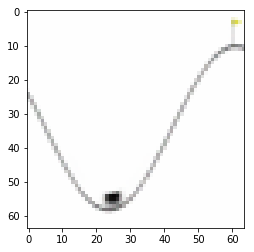

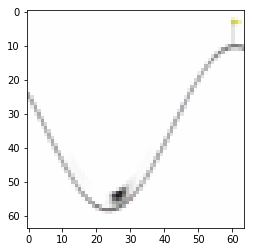

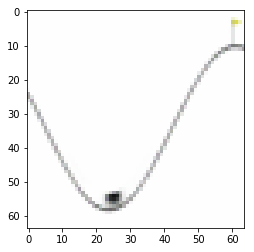

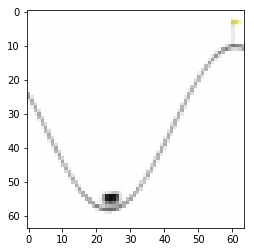

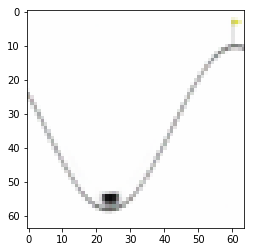

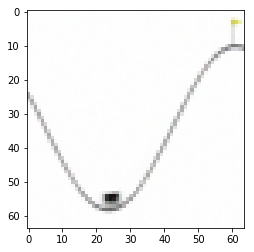

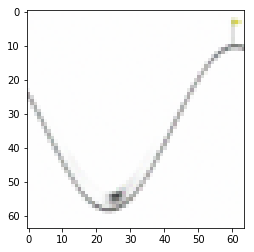

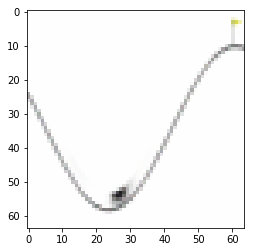

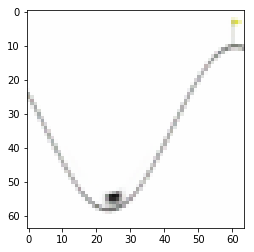

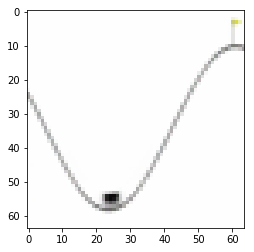

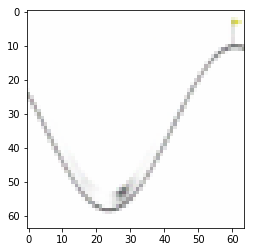

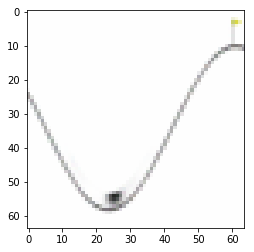

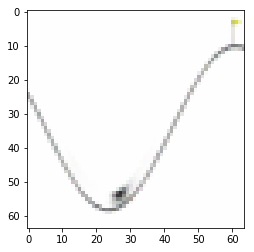

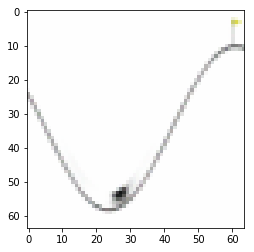

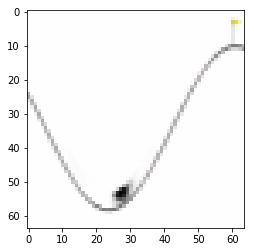

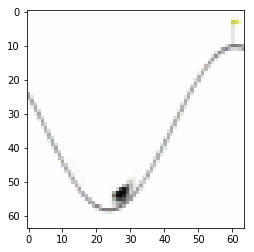

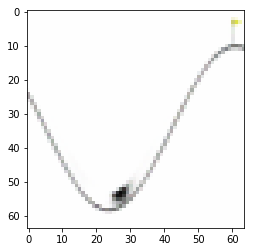

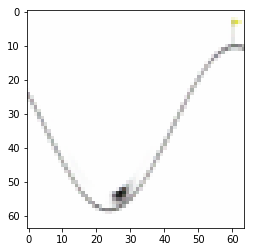

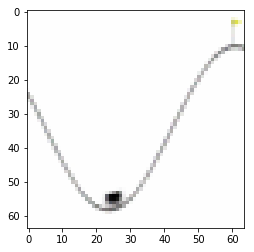

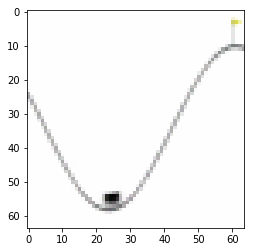

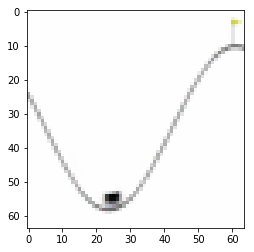

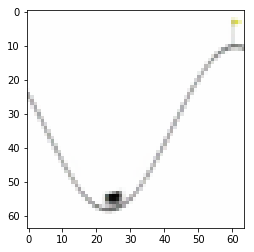

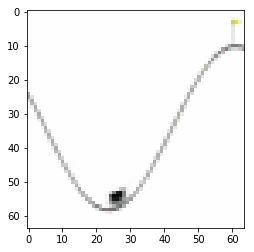

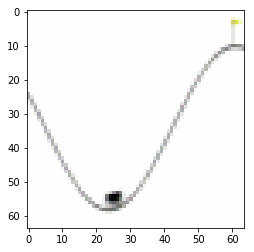

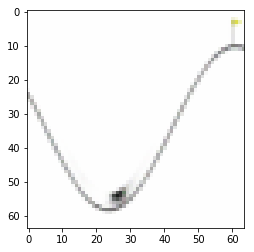

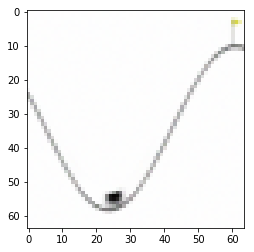

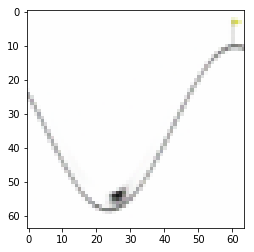

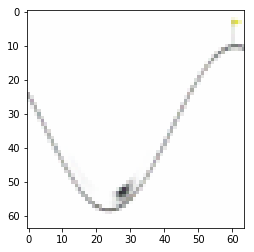

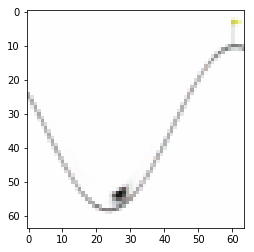

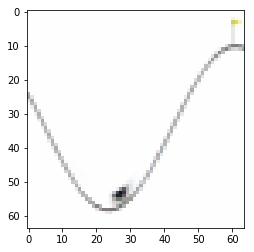

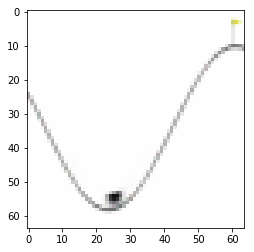

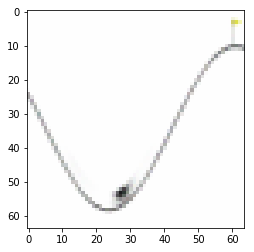

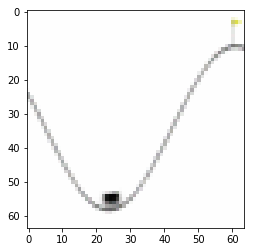

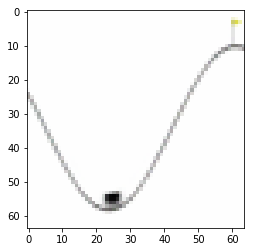

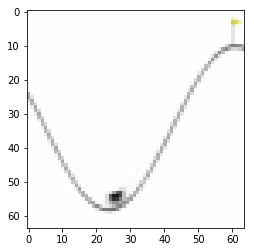

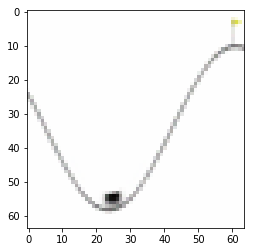

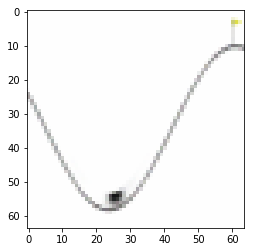

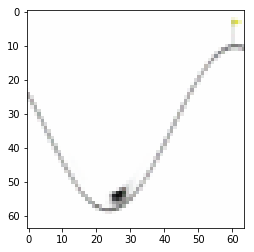

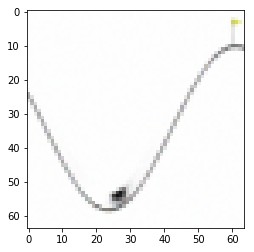

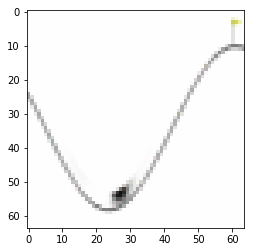

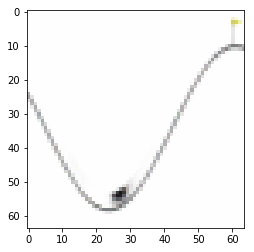

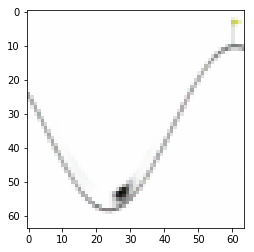

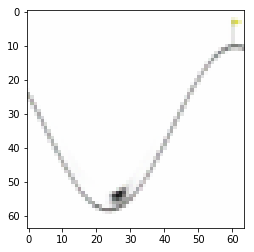

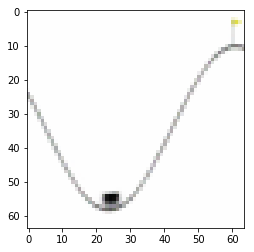

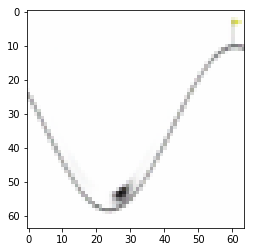

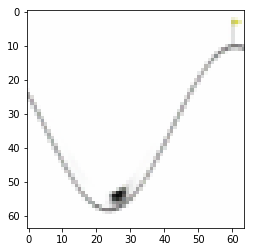

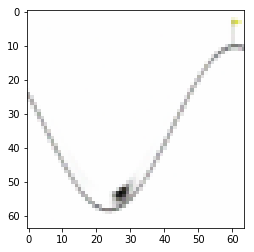

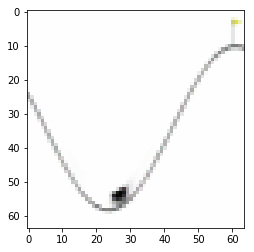

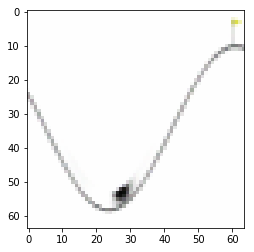

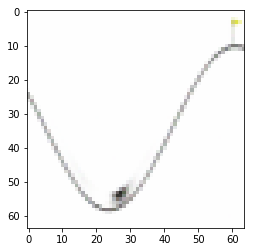

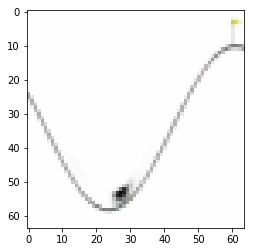

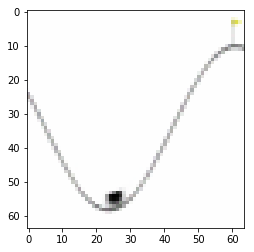

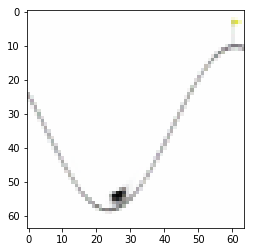

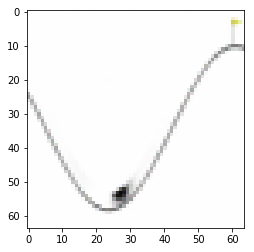

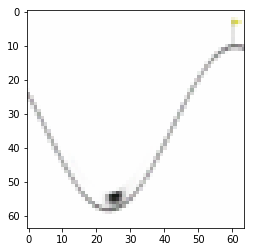

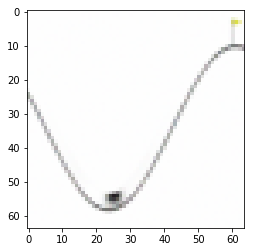

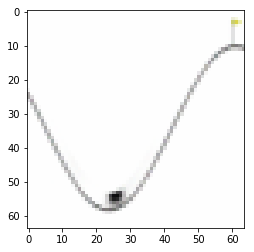

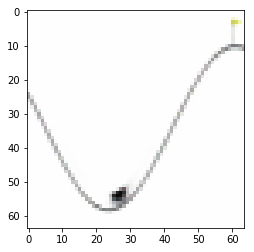

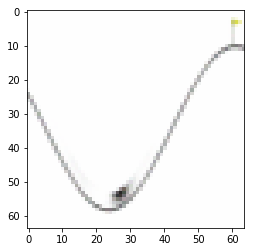

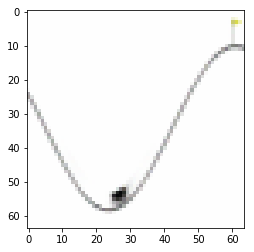

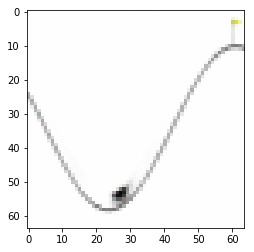

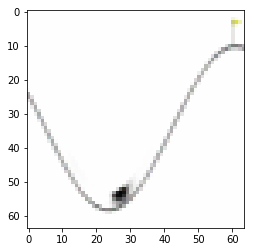

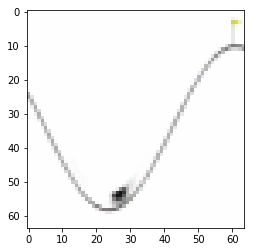

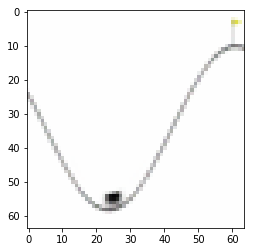

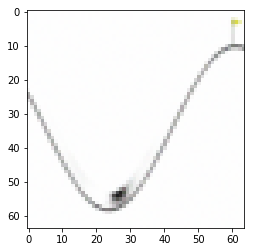

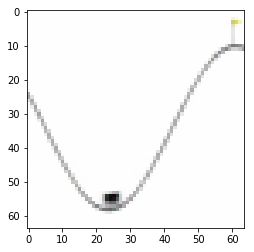

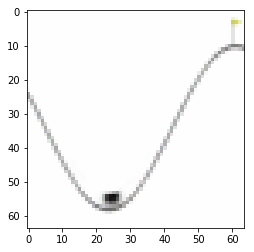

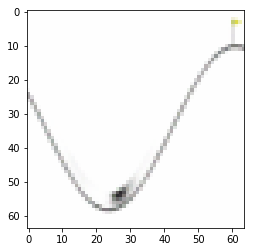

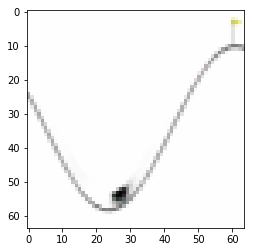

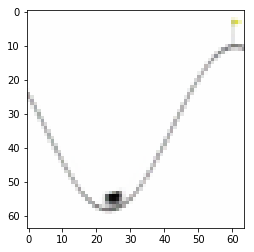

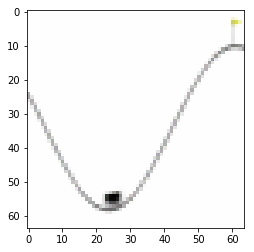

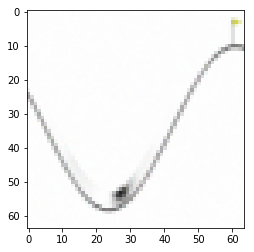

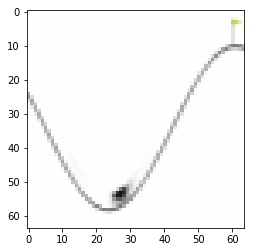

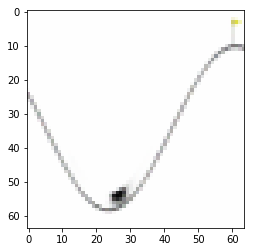

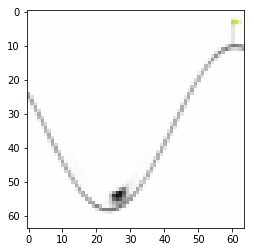

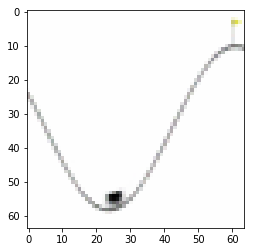

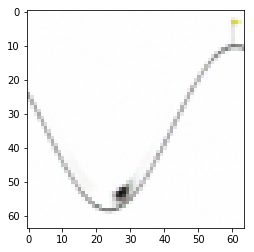

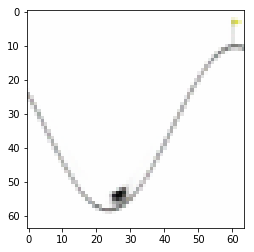

In [255]:

old_rnn_hidden = None
for i in range(100):
    mus, logsigmas, logpis, rnn_out, rnn_hidden = model(curr_latent, torch.randint(0,3,(1,1,1)).to(device) , old_rnn_hidden)
    old_rnn_hidden = (torch.tensor(rnn_hidden[0]).detach(), torch.tensor(rnn_hidden[1]).detach())
    next_latent = sample_gmm(mus, logsigmas, logpis)
    
    plt.imshow(vae.decoder(next_latent).squeeze().detach().cpu().numpy().transpose((1,2,0)))
    plt.show()
    
    curr_latent = next_latent.unsqueeze(0).unsqueeze(0)